In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import joblib

In [135]:
df = pd.read_csv('../data/data.csv')
df

,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,...,WT10,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT21,WT22
0,US1TXDA0021,"RICHARDSON 1.7 WSW, TX US",2008-08-28,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US1TXDA0021,"RICHARDSON 1.7 WSW, TX US",2008-08-29,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US1TXDA0021,"RICHARDSON 1.7 WSW, TX US",2008-08-30,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US1TXDA0021,"RICHARDSON 1.7 WSW, TX US",2008-08-31,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US1TXDA0021,"RICHARDSON 1.7 WSW, TX US",2008-09-01,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91895,US1TXDA0091,"GARLAND 2.5 NW, TX US",2018-12-03,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91896,US1TXDA0091,"GARLAND 2.5 NW, TX US",2018-12-04,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91897,US1TXDA0091,"GARLAND 2.5 NW, TX US",2018-12-05,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91898,US1TXDA0091,"GARLAND 2.5 NW, TX US",2018-12-06,NaN,0.28,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91900 entries, 0 to 91899
Data columns (total 29 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  91900 non-null  object 
 1   NAME     91900 non-null  object 
 2   DATE     91900 non-null  object 
 3   AWND     15335 non-null  float64
 4   PRCP     91325 non-null  float64
 5   SNOW     52798 non-null  float64
 6   SNWD     10805 non-null  float64
 7   TAVG     4487 non-null   float64
 8   TMAX     15336 non-null  float64
 9   TMIN     15354 non-null  float64
 10  WT01     3966 non-null   float64
 11  WT02     338 non-null    float64
 12  WT03     1950 non-null   float64
 13  WT04     46 non-null     float64
 14  WT05     252 non-null    float64
 15  WT06     70 non-null     float64
 16  WT07     100 non-null    float64
 17  WT08     1950 non-null   float64
 18  WT09     19 non-null     float64
 19  WT10     2 non-null      float64
 20  WT11     12 non-null     float64
 21  WT13     428

In [137]:
df.columns = df.columns.str.lower()
# set the index to date
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'],inplace=True)
df

,station,name,date,awnd,prcp,snow,snwd,tavg,tmax,tmin,...,wt10,wt11,wt13,wt14,wt15,wt16,wt17,wt18,wt21,wt22
date,,,,,,,,,,,,,,,,,,,,,
2008-08-28,US1TXDA0021,"RICHARDSON 1.7 WSW, TX US",2008-08-28,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-29,US1TXDA0021,"RICHARDSON 1.7 WSW, TX US",2008-08-29,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-30,US1TXDA0021,"RICHARDSON 1.7 WSW, TX US",2008-08-30,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-31,US1TXDA0021,"RICHARDSON 1.7 WSW, TX US",2008-08-31,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-09-01,US1TXDA0021,"RICHARDSON 1.7 WSW, TX US",2008-09-01,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-03,US1TXDA0091,"GARLAND 2.5 NW, TX US",2018-12-03,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-04,US1TXDA0091,"GARLAND 2.5 NW, TX US",2018-12-04,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-05,US1TXDA0091,"GARLAND 2.5 NW, TX US",2018-12-05,NaN,0.00,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
df.dtypes

station            object
name               object
date       datetime64[ns]
awnd              float64
prcp              float64
snow              float64
snwd              float64
tavg              float64
tmax              float64
tmin              float64
wt01              float64
wt02              float64
wt03              float64
wt04              float64
wt05              float64
wt06              float64
wt07              float64
wt08              float64
wt09              float64
wt10              float64
wt11              float64
wt13              float64
wt14              float64
wt15              float64
wt16              float64
wt17              float64
wt18              float64
wt21              float64
wt22              float64
dtype: object

In [139]:
null_pct = df.apply(pd.isnull).sum()/df.shape[0]
null_pct

station    0.000000
name       0.000000
date       0.000000
awnd       0.833134
prcp       0.006257
snow       0.425484
snwd       0.882427
tavg       0.951175
tmax       0.833123
tmin       0.832927
wt01       0.956844
wt02       0.996322
wt03       0.978781
wt04       0.999499
wt05       0.997258
wt06       0.999238
wt07       0.998912
wt08       0.978781
wt09       0.999793
wt10       0.999978
wt11       0.999869
wt13       0.995343
wt14       0.998575
wt15       0.999967
wt16       0.993580
wt17       0.999978
wt18       0.999630
wt21       0.999978
wt22       0.999956
dtype: float64

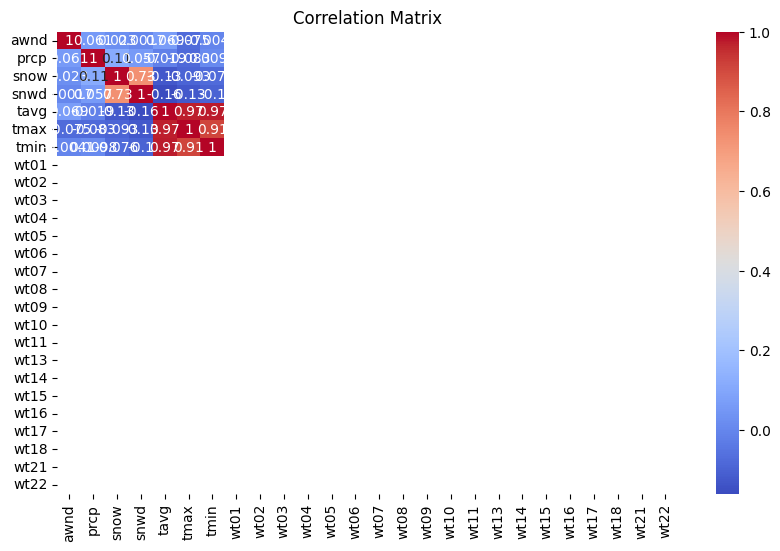

In [140]:
num_cols = df.drop(columns=['station','name','date'])
correlation = num_cols.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation,annot=True,cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [141]:
df.drop(
    columns=['station','name','date','wt01','wt02','wt03','wt04','wt05','wt06','wt07','wt08','wt09','wt10','wt11','wt13','wt14','wt15','wt16','wt17','wt18','wt21','wt22'],
            inplace=True
)
df

,awnd,prcp,snow,snwd,tavg,tmax,tmin
date,,,,,,,
2008-08-28,NaN,0.00,0.0,NaN,NaN,NaN,NaN
2008-08-29,NaN,0.00,0.0,NaN,NaN,NaN,NaN
2008-08-30,NaN,0.00,0.0,NaN,NaN,NaN,NaN
2008-08-31,NaN,0.00,0.0,NaN,NaN,NaN,NaN
2008-09-01,NaN,0.00,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2018-12-03,NaN,0.00,0.0,NaN,NaN,NaN,NaN
2018-12-04,NaN,0.00,0.0,NaN,NaN,NaN,NaN
2018-12-05,NaN,0.00,0.0,NaN,NaN,NaN,NaN


In [142]:
df = df.copy()

In [143]:
null_pct = df.apply(pd.isnull).sum() / df.shape[0]
null_pct

awnd    0.833134
prcp    0.006257
snow    0.425484
snwd    0.882427
tavg    0.951175
tmax    0.833123
tmin    0.832927
dtype: float64

In [144]:
df.drop(df.columns[null_pct > .9],axis=1,inplace=True)
df

,awnd,prcp,snow,snwd,tmax,tmin
date,,,,,,
2008-08-28,NaN,0.00,0.0,NaN,NaN,NaN
2008-08-29,NaN,0.00,0.0,NaN,NaN,NaN
2008-08-30,NaN,0.00,0.0,NaN,NaN,NaN
2008-08-31,NaN,0.00,0.0,NaN,NaN,NaN
2008-09-01,NaN,0.00,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...
2018-12-03,NaN,0.00,0.0,NaN,NaN,NaN
2018-12-04,NaN,0.00,0.0,NaN,NaN,NaN
2018-12-05,NaN,0.00,0.0,NaN,NaN,NaN


In [145]:
df.dropna(subset=['tmax','tmin','prcp'],inplace=True)

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15274 entries, 2022-05-01 to 2025-07-11
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   awnd    15248 non-null  float64
 1   prcp    15274 non-null  float64
 2   snow    9811 non-null   float64
 3   snwd    9829 non-null   float64
 4   tmax    15274 non-null  float64
 5   tmin    15274 non-null  float64
dtypes: float64(6)
memory usage: 835.3 KB


In [147]:
df.dtypes

awnd    float64
prcp    float64
snow    float64
snwd    float64
tmax    float64
tmin    float64
dtype: object

In [148]:
df['target'] = df.shift(-1)['tmax']
df['target'] = df['target'].ffill()
df['tmax_lag1'] = df['tmax'].shift(1)
df['tmin_lag1'] = df['tmin'].shift(1)
df['prcp_lag1'] = df['prcp'].shift(1)
df

,awnd,prcp,snow,snwd,tmax,tmin,target,tmax_lag1,tmin_lag1,prcp_lag1
date,,,,,,,,,,
2022-05-01,5.14,0.00,NaN,NaN,84.0,51.0,85.0,NaN,NaN,NaN
2022-05-02,12.53,0.49,NaN,NaN,85.0,65.0,76.0,84.0,51.0,0.00
2022-05-03,6.93,0.56,NaN,NaN,76.0,56.0,86.0,85.0,65.0,0.49
2022-05-04,7.38,0.00,NaN,NaN,86.0,59.0,76.0,76.0,56.0,0.56
2022-05-05,6.26,0.59,NaN,NaN,76.0,57.0,83.0,86.0,59.0,0.00
...,...,...,...,...,...,...,...,...,...,...
2025-07-07,5.82,0.00,NaN,NaN,90.0,72.0,96.0,90.0,73.0,0.00
2025-07-08,6.04,0.39,NaN,NaN,96.0,70.0,94.0,90.0,72.0,0.00
2025-07-09,5.37,0.56,NaN,NaN,94.0,70.0,94.0,96.0,70.0,0.39


In [149]:
tss = TimeSeriesSplit(n_splits=5,test_size=30,gap=1)
df = df.sort_index()
X = df.columns.drop('target')
y = 'target'

In [150]:
def pct_diff(old,new):
    return (new - old) / old

def compute_rolling(df,horizon,col):
    label = f"rolling_{horizon}_{col}"
    df[label] = df[col].rolling(horizon).mean()
    df[f"{label}_pct"] = pct_diff(df[label],df[col])
    return df
rolling_horizon = [3,14]
for horizon in rolling_horizon:
    for col in ['tmax','tmin','prcp']:
        df = compute_rolling(df,horizon,col)

df = df.iloc[14:,:]
df = df.fillna(0)

def expand_mean(df):
    return df.expanding().mean()

for col in ['tmax','tmin','prcp']:
    df[f"month_avg_{col}"] = df[col].groupby(df.index.month,group_keys=False).transform(expand_mean)
    df[f"day_avg_{col}"] = df[col].groupby(df.index.day_of_year,group_keys=False).transform(expand_mean)

In [151]:
fold=0
preds=[]
scores=[]
for train_idx, test_idx in tss.split(df):
    train=df.iloc[train_idx]
    test=df.iloc[test_idx]
    X = df.columns[~df.columns.isin(['target','tmax'])]
    y = 'target'
    X_train = train[X]
    y_train = train[y]
    X_test = test[X]
    y_test = test[y]

    model = xgb.XGBRegressor(base_score=0.5,
                                 n_estimators=1000,
                                 booster='gbtree',
                                 early_stopping_rounds=50,
                                 max_depth=4,
                                 subsample=0.8,
                                 colsample_bytree=0.8,
                                 objective='reg:squarederror',
                                 learning_rate=0.01,
                                 random_state=42
                                )
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)
    y_pred = model.predict(X_test)
    preds.append(y_pred)

    train_pred = model.predict(X_train)
    train_rmse = mean_squared_error(y_train, train_pred)
    test_rmse = mean_squared_error(y_test, y_pred)

    print(f"✅ Fold {fold+1} | Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}")

    fold += 1

[0]	validation_0-rmse:78.97274	validation_1-rmse:88.78849
[100]	validation_0-rmse:29.65127	validation_1-rmse:33.33612
[200]	validation_0-rmse:12.38112	validation_1-rmse:13.09681
[300]	validation_0-rmse:7.29449	validation_1-rmse:6.09115
[400]	validation_0-rmse:6.19781	validation_1-rmse:4.05303
[500]	validation_0-rmse:5.95138	validation_1-rmse:3.51998
[600]	validation_0-rmse:5.85540	validation_1-rmse:3.36572
[700]	validation_0-rmse:5.78824	validation_1-rmse:3.31337
[800]	validation_0-rmse:5.73036	validation_1-rmse:3.28519
[900]	validation_0-rmse:5.67509	validation_1-rmse:3.26981
[967]	validation_0-rmse:5.63956	validation_1-rmse:3.26964
✅ Fold 1 | Train RMSE: 32.11 | Test RMSE: 10.67
[0]	validation_0-rmse:78.99309	validation_1-rmse:85.49675
[100]	validation_0-rmse:29.65754	validation_1-rmse:30.27160
[200]	validation_0-rmse:12.38057	validation_1-rmse:11.03142
[300]	validation_0-rmse:7.29125	validation_1-rmse:6.67066
[397]	validation_0-rmse:6.20789	validation_1-rmse:6.57627
✅ Fold 2 | Train

In [152]:
joblib.dump(model,'xgb_model.joblib')

['xgb_model.joblib']

In [153]:
df.to_csv('contain_null_data.csv',index=False)